## Connection Wind and Melt
Here, we show the distribution between in individual ensemble members for the connection between the wind and melt.

In [1]:
#Importing relevant functions
from functions.correlation_maps import showCorMapAxis, showLagMapAxis
from functions.loading_and_processing_data import loadMITgcmData, loadTimeSeriesData, detrend_and_average_MITgcmData
from functions.other_functions import computeBuoyancy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

#Importing functions from Kaitlin
import sys
sys.path.append('/data/hpcdata/users/grejan/mitgcm/')
from mitgcm_python_master.grid import ERA5Grid, PACEGrid, Grid, dA_from_latlon, pierre_obs_grid
from mitgcm_python_master.plot_utils.labels import latlon_axes

#Create grid
gp='/data/oceans_output/shelf/kaight/mitgcm/PAS_grid/'
grid = Grid(gp)

/users/kaight/MITgcm/utils/python/MITgcmutils/MITgcmutils/netcdf.py:330: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if hasattr(self, 'mode') and self.mode is 'w':
/users/kaight/MITgcm/utils/python/MITgcmutils/MITgcmutils/netcdf.py:705: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if typecode is not 'c':


In [3]:
%%capture
#Load Wind Data
vwind=loadTimeSeriesData(filename='timeseries_vwind', members='all', kind='timeseries')
vwind['time']=vwind.indexes['time'].to_datetimeindex()
full=loadTimeSeriesData(filename='timeseries_final', members='all', kind='old')
full['time']=full.indexes['time'].to_datetimeindex()

#Detrend the wind
full_dt=full.sel(time=slice('1920', '2013')).copy()
vwind_dt=vwind.sel(time=slice('1920', '2013')).copy()

for j in vwind_dt.variables:
    vwind_dt[j]=detrend_and_average_MITgcmData(vwind_dt, var=j, window=1)
for j in full_dt.variables:
    full_dt[j]=detrend_and_average_MITgcmData(full_dt, var=j, window=1)

In [2]:
#Create function to compute cross correlation.
def crosscorr(a,b, lags=np.arange(0, 24)):
    '''
    INPUT:
    a (xr.DataArray): 1st time series to correlate
    b (xr.DataArray): 2nd time series to correlate
    lags (list or np.array): for which lag to correlate (positive means timeseries a is leading)
    
    RETURN:
    corsmax (list): maximum absolute correlation coefficient per member.
    lagsmax (list): lag corresponding to corsmax (per member) [months].
    '''
    corsmax=[]
    lagsmax=[]
    for ensnr in a.ens:
        cors=[]
        for i in lags:
            cors+=[xr.corr(a.sel(ens=ensnr).shift(time=i),b.sel(ens=ensnr), dim='time').values]
        #Select maximum absolute correlation and lag.
        corsmax+=[max(np.min(cors), np.max(cors), key=abs)]
        lagsmax+=np.where([np.round(abs(j),3) for j in cors]==np.round(corsmax[-1]))[0]
    return corsmax, lagsmax

In [5]:
#Perform cross-correlation with normal winds
b=full_dt['dotson_to_cosgrove_massloss'].rolling(time=60).mean()

a=full_dt['amundsen_shelf_break_uwind_avg'].rolling(time=60).mean()
uwindcor, uwindlags=crosscorr(a,b)

a=vwind_dt['inner_amundsen_shelf_vwind_avg'].rolling(time=60).mean()
vwindcor,vwindlags=crosscorr(a,b)

In [31]:
#Perform cross-correlation with cumulative winds
a=full_dt['amundsen_shelf_break_uwind_avg'].cumsum().rolling(time=60).mean()
cumuwindcor, cumuwindlags=crosscorr(a,b)

a=vwind_dt['inner_amundsen_shelf_vwind_avg'].cumsum().rolling(time=60).mean()
cumvwindcor, cumvwindlags=crosscorr(a,b)

Start preparing for correlation map!
NOTE: this is version 3!
...Plotting
Start preparing for correlation map!
NOTE: this is version 3!
...Plotting


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


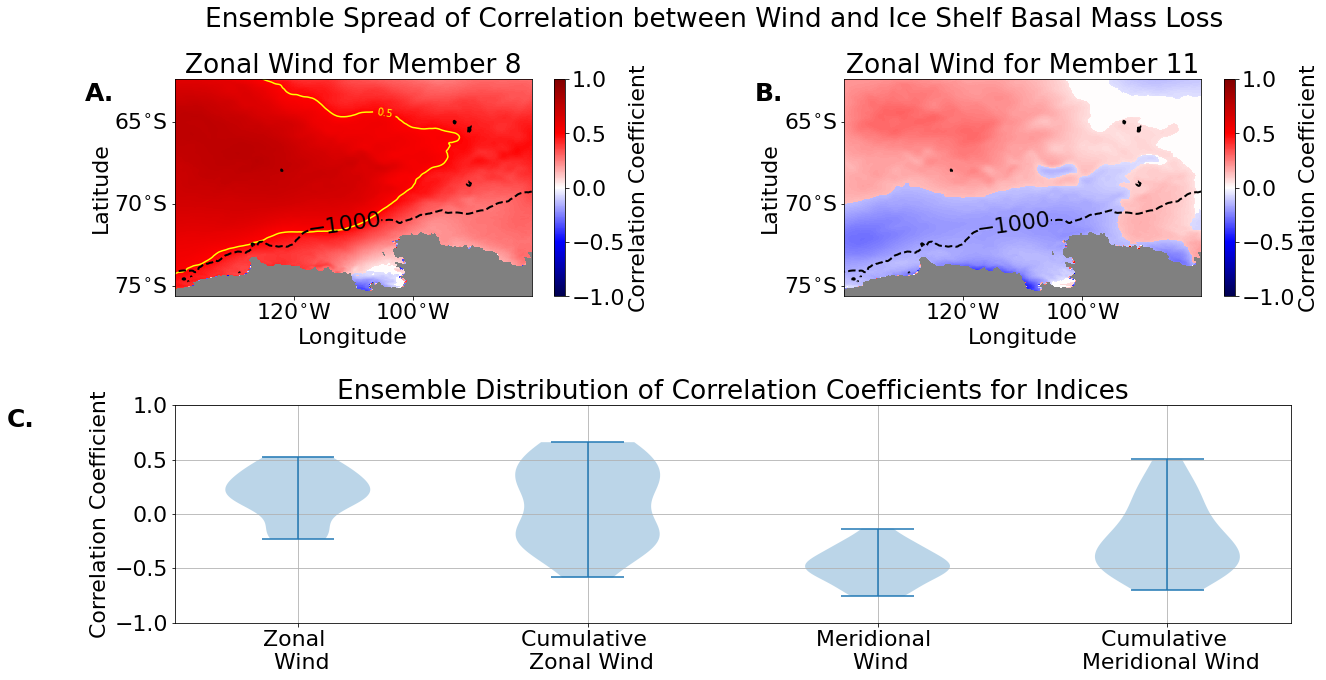

In [38]:
#Create figure showing distribution within ensemble
fig=plt.figure(figsize=(20,10))
window=60

#Select high melt member (8)
members=[7,8]
ax=plt.subplot(2,2,1)
ax=showCorMapAxis(ax=ax, members=members,
                  data=None, datafn='EXFuwind', datavar='EXFuwind', datakind='maps',
                  ind=None, indfn='timeseries_final', indvar='dotson_to_cosgrove_massloss', lags=range(-24, 0),
                  detrend=True, window=window, title='Zonal Wind for Member '+str(members[-1]), ymax=None, save=True, savefn='EXFuwind_dotson_to_cosgrove_'+str(window)+'month_dt',
                  draw_box=False, box_x=[360-115, 360-102],box_y=[-71.8, -70.2],
                  inverse=False,
                  give_back=False, deseasonalize=True, cumsum_map=False)

#Select low melt member (11)
members=[10,11]
ax=plt.subplot(2,2,2)
ax=showCorMapAxis(ax=ax, members=members,
                  data=None, datafn='EXFuwind', datavar='EXFuwind', datakind='maps',
                  ind=None, indfn='timeseries_final', indvar='dotson_to_cosgrove_massloss', lags=range(-24, 0),
                  detrend=True, window=window, title='Zonal Wind for Member '+str(members[-1]), ymax=None, save=True, savefn='EXFuwind_dotson_to_cosgrove_'+str(window)+'month_dt',
                  draw_box=False, box_x=[360-115, 360-102],box_y=[-71.8, -70.2],
                  inverse=False,
                  give_back=False, deseasonalize=True, cumsum_map=False)


#Create violinplot with spread of correlation within the ensemble.
ax=plt.subplot(2,1,2)
plt.violinplot(np.vstack((uwindcor, cumuwindcor, vwindcor, cumvwindcor)).T)
plt.ylim([-1, 1])
plt.grid()
plt.xticks(np.arange(4)+1, ['Zonal \n Wind', 'Cumulative \n Zonal Wind', 'Meridional \n Wind', 'Cumulative \n Meridional Wind'])
plt.title('Ensemble Distribution of Correlation Coefficients for Indices')
plt.ylabel('Correlation Coefficient')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle('Ensemble Spread of Correlation between Wind and Ice Shelf Basal Mass Loss')

for n, ax in enumerate(fig.axes[::2][:-1]):
    latlon_axes(ax, y=grid.lat_1d, x=grid.lon_1d)
    
#Add letters to subplot
import string
for n, ax in enumerate(fig.axes[::2]):
    if n==2:
        ax.text(-0.15, 0.9, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
            size=25, weight='bold')
    else:
        ax.text(-0.25, 0.9, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
            size=25, weight='bold')

plt.savefig('../03_output/other/distribution_within_wind.png')

## BONUS

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from functions.loading_and_processing_data import read_all_data

import matplotlib.colors as colors
norm = colors.TwoSlopeNorm(vcenter=0)

In [3]:
#Reading the data.
full='/data/hpcdata/users/grejan/mitgcm/data'
total={}
units={}
longnames={}
#from unixFunctionsMITgcm_final import read_all_data
total, units, longnames=read_all_data(full, total, units, longnames, kind='isotherm')
total, units, longnames=read_all_data(full, total, units, longnames, kind='final')
# total, units, longnames=read_all_data(full, total, units, longnames, kind='ohc')
# total, units, longnames=read_all_data(full, total, units, longnames, kind='seaice')
# total, units, longnames=read_all_data(full, total, units, longnames, kind='trough')
# total, units, longnames=read_all_data(full, total, units, longnames, kind='forcing')

In [13]:
ens=1

In [75]:
def check_correlation(ens=1):
    a=(total['amundsen_shelf_break_uwind_avg']['ens'+str(ens).zfill(2)]['1920':'2013']
       -total['amundsen_shelf_break_uwind_avg']['ens'+str(ens).zfill(2)]['1920':'2013'].rolling(25*12,center=True, min_periods=5*12).mean())
    b=(total['dotson_to_cosgrove_massloss']['ens'+str(ens).zfill(2)]['1920':'2013']
       -total['dotson_to_cosgrove_massloss']['ens'+str(ens).zfill(2)]['1920':'2013'].rolling(25*12,center=True, min_periods=5*12).mean())

    a=a.rolling(60,center=True).mean()
    b=b.rolling(60,center=True).mean()
    
    corwin=120
    k=a.rolling(corwin, center=True).corr(b)

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title('Rolling Correlation')
    k.plot(c='r')
    plt.subplot(1,2,2)
    a.plot(label='Wind')
    plt.legend()
    plt.twinx()
    b.plot(c='b', label='Melt')
    plt.legend()

    
    #Hypothesis:
    # - Temperature
    # - Surface Buoyancy
    # - Meridional Wind
    # - Surface stress curl


    THETA=xr.open_dataarray('../02_data/maps/THETA_depth_integrated_ens'+str(ens)+'.nc')
    try:
        THETA['time']=THETA.indexes['time'].to_datetimeindex()
    except:
        print('Oeps')

    BUOY=xr.open_dataarray('../02_data/maps/oceFWflx_ens'+str(ens)+'.nc')
    try:
        BUOY['time']=BUOY.indexes['time'].to_datetimeindex()
    except:
        print('Oeps')

    EXFvwind=xr.open_dataarray('../02_data/maps/EXFvwind_ens'+str(ens)+'.nc')
    try:
        EXFvwind['time']=EXFvwind.indexes['time'].to_datetimeindex()
    except:
        print('Oeps')

    curlTAU=xr.open_dataarray('../02_data/maps/curlTAU_ens'+str(ens)+'.nc')
    try:
        curlTAU['time']=curlTAU.indexes['time'].to_datetimeindex()
    except:
        print('Oeps')
        
        
    l=k.to_xarray().rename({'index':'time'})
    THETA=THETA-THETA.rolling(time=12*25, center=True, min_periods=5*12).mean()
    THETA=THETA.rolling(time=12, center=True).mean()
    THETA1=THETA.where(l>0.25).mean(dim='time')
    THETA2=THETA.where(l<-0.25).mean(dim='time')
    BUOY=BUOY-BUOY.rolling(time=12*25, center=True, min_periods=5*12).mean()
    BUOY=BUOY.rolling(time=12, center=True).mean()
    BUOY1=BUOY.where(l>0.25).mean(dim='time')
    BUOY2=BUOY.where(l<0.25).mean(dim='time')
    EXFvwind=EXFvwind-EXFvwind.rolling(time=12*25, center=True, min_periods=5*12).mean()
    EXFvwind=EXFvwind.rolling(time=12, center=True).mean()
    EXFvwind1=EXFvwind.where(l>0.25).mean(dim='time')
    EXFvwind2=EXFvwind.where(l<0.25).mean(dim='time')
    curlTAU=curlTAU-curlTAU.rolling(time=12*25, center=True, min_periods=5*12).mean()
    curlTAU=curlTAU.rolling(time=12, center=True).mean()
    curlTAU1=curlTAU.where(l>0.25).mean(dim='time')
    curlTAU2=curlTAU.where(l<0.25).mean(dim='time')
    
    
    plt.figure(figsize=(30,15))
    plt.subplot(4,2,1)
    vmax=THETA1.quantile(0.95)
    vmin=THETA1.quantile(0.05)
    if vmax<abs(vmin):
        vmax=abs(vmin)

    plt.pcolor(THETA1.where(THETA1.YC<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
    plt.colorbar()
    plt.title('THETA, positive corr')
    plt.subplot(4,2,2)
    plt.pcolor(THETA2.where(THETA2.YC<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
    plt.colorbar()
    plt.title('THETA, negative corr')

    vmax=BUOY1.quantile(0.95)
    vmin=BUOY1.quantile(0.05)
    if vmax<abs(vmin):
        vmax=abs(vmin)

    plt.subplot(4,2,3)
    plt.pcolor(BUOY1.where(BUOY1.YC<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
    plt.colorbar()
    plt.title('oceFWflx, positive corr')
    plt.subplot(4,2,4)
    plt.pcolor(BUOY2.where(BUOY2.YC<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
    plt.colorbar()
    plt.title('oceFWflx, negative corr')


    vmax=EXFvwind1.quantile(0.95)
    vmin=EXFvwind1.quantile(0.05)
    if vmax<abs(vmin):
        vmax=abs(vmin)
    plt.subplot(4,2,5)
    plt.pcolor(EXFvwind1.where(EXFvwind1.YC<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
    plt.colorbar()
    plt.title('EXFvwind, positive corr')
    plt.subplot(4,2,6)
    plt.pcolor(EXFvwind2.where(EXFvwind2.YC<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
    plt.colorbar()
    plt.title('EXFvwind, negative corr')

    
    vmax=curlTAU1.quantile(0.95)
    vmin=curlTAU1.quantile(0.05)
    if vmax<abs(vmin):
        vmax=abs(vmin)
    plt.subplot(4,2,7)
    plt.pcolor(curlTAU1.where(curlTAU1.YG<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
    plt.colorbar()
    plt.title('curlTAU, positive corr')

    plt.subplot(4,2, 8)
    plt.pcolor(curlTAU2.where(curlTAU2.YG<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
    plt.colorbar()
    plt.title('curlTAU, negative corr')

    return THETA1, THETA2, BUOY1, BUOY2, EXFvwind1, EXFvwind2, curlTAU1, curlTAU2


/tmp/ipykernel_7770/1493048411.py:34: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  THETA['time']=THETA.indexes['time'].to_datetimeindex()
/tmp/ipykernel_7770/1493048411.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  BUOY['time']=BUOY.indexes['time'].to_datetimeindex()
/tmp/ipykernel_7770/1493048411.py:46: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between date

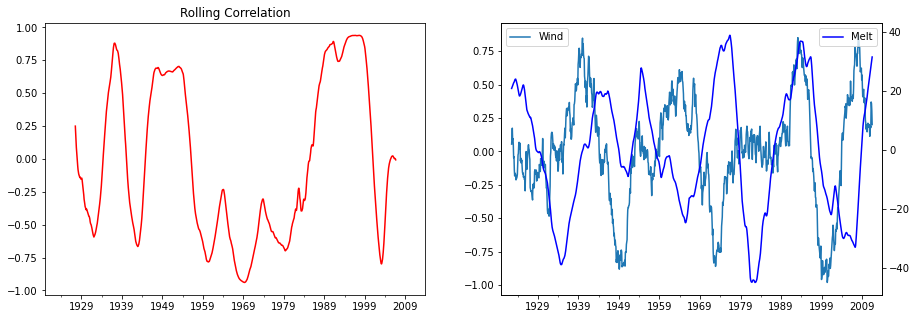

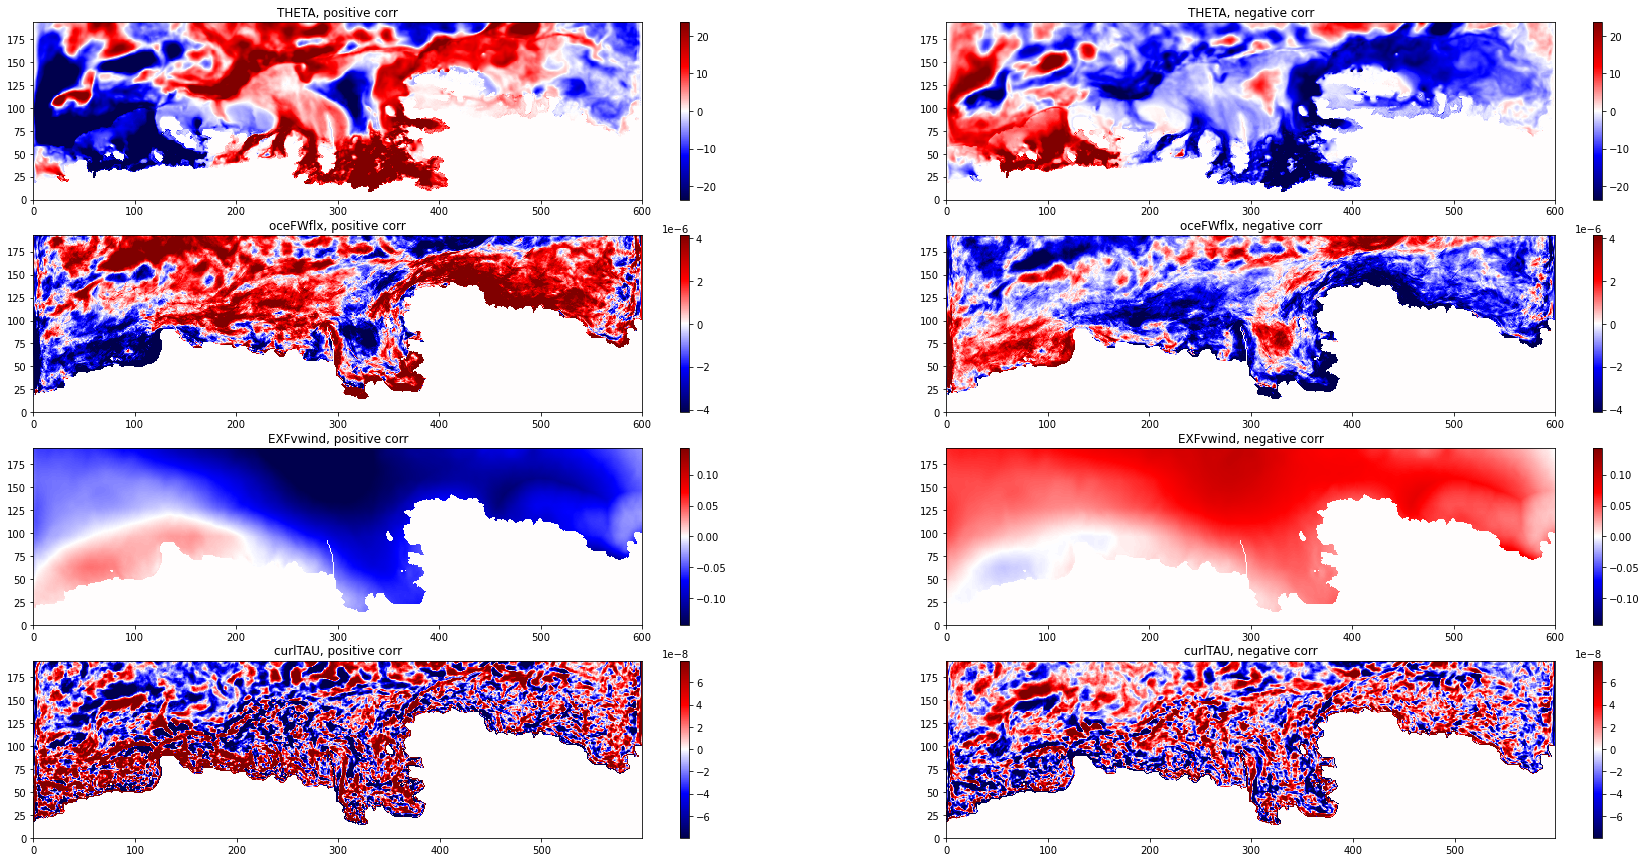

In [76]:
THETA1X, THETA2X, BUOY1X, BUOY2X, EXFvwind1X, EXFvwind2X, curlTAU1X, curlTAU2X=check_correlation(ens=1)

/tmp/ipykernel_7770/1493048411.py:34: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  THETA['time']=THETA.indexes['time'].to_datetimeindex()
/tmp/ipykernel_7770/1493048411.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  BUOY['time']=BUOY.indexes['time'].to_datetimeindex()
/tmp/ipykernel_7770/1493048411.py:46: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between date

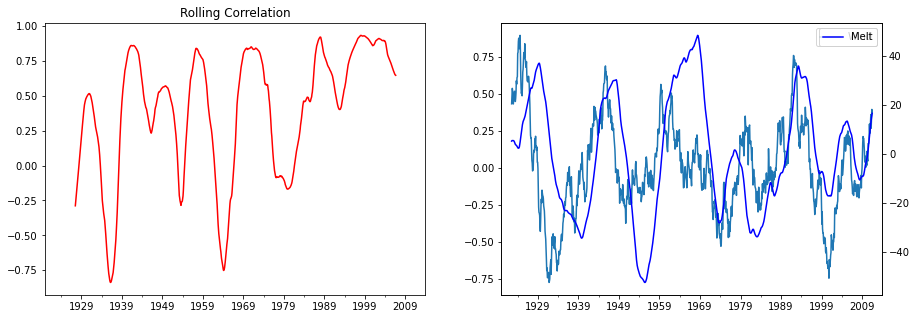

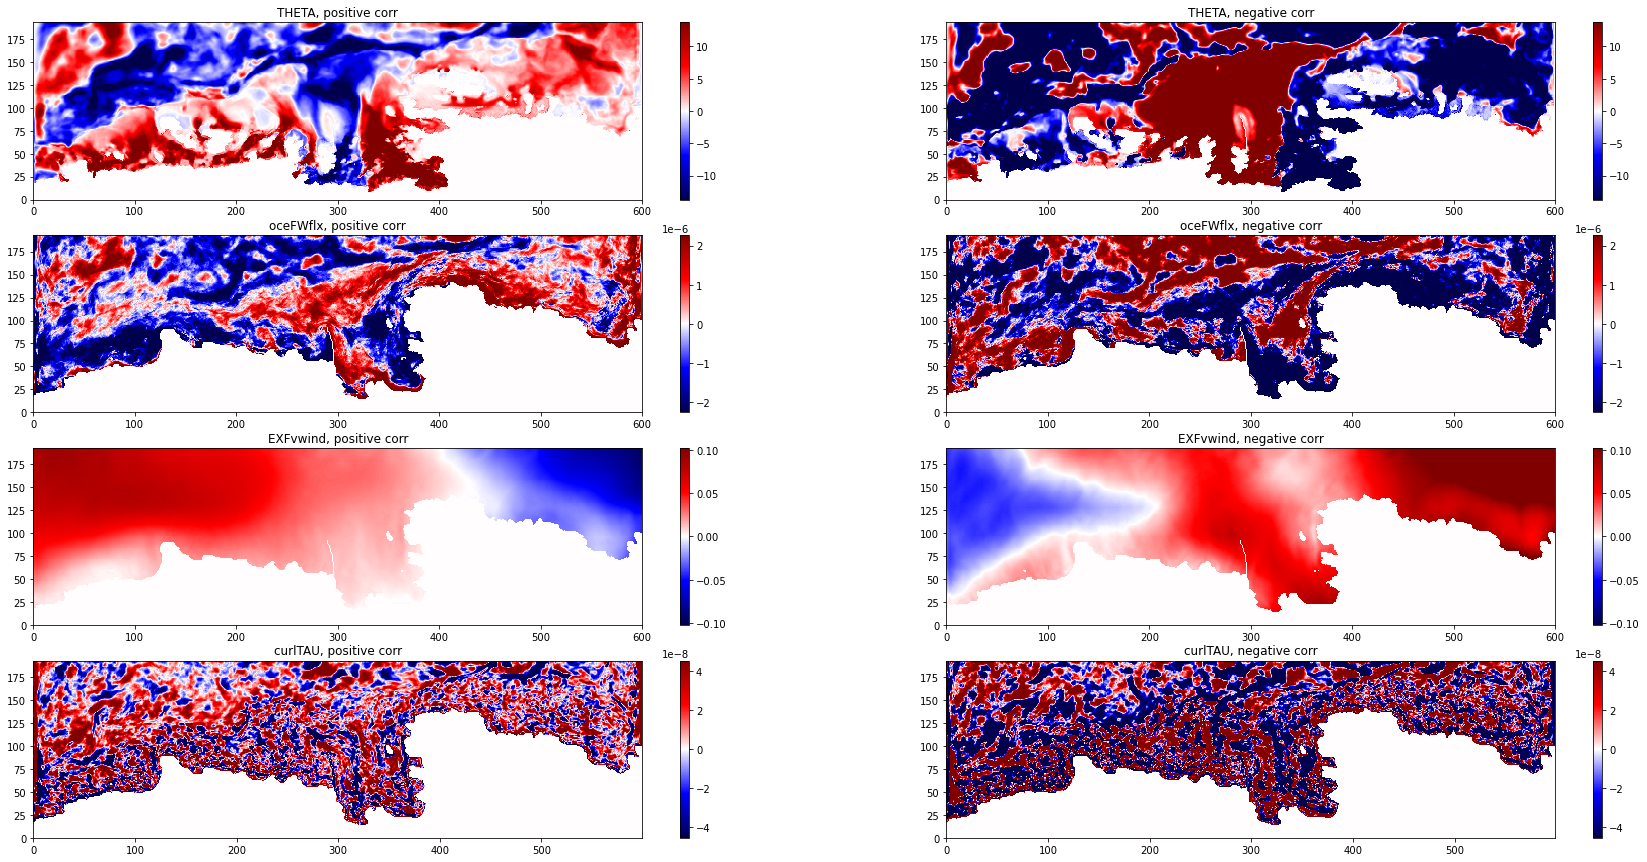

In [77]:
THETA1, THETA2, BUOY1, BUOY2, EXFvwind1, EXFvwind2, curlTAU1, curlTAU2=check_correlation(ens=2)

In [78]:
THETA1X=xr.concat([THETA1X, THETA1], dim='ens')
THETA2X=xr.concat([THETA2X, THETA2], dim='ens')

BUOY1X=xr.concat([BUOY1X, BUOY1], dim='ens')
BUOY2X=xr.concat([BUOY2X, BUOY2], dim='ens')

EXFvwind1X=xr.concat([EXFvwind1X, EXFvwind1], dim='ens')
EXFvwind2X=xr.concat([EXFvwind2X, EXFvwind2], dim='ens')

curlTAU1X=xr.concat([curlTAU1X, curlTAU1], dim='ens')
curlTAU2X=xr.concat([curlTAU2X, curlTAU2], dim='ens')

/tmp/ipykernel_7770/1493048411.py:34: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  THETA['time']=THETA.indexes['time'].to_datetimeindex()
/tmp/ipykernel_7770/1493048411.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  BUOY['time']=BUOY.indexes['time'].to_datetimeindex()
/tmp/ipykernel_7770/1493048411.py:46: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between date

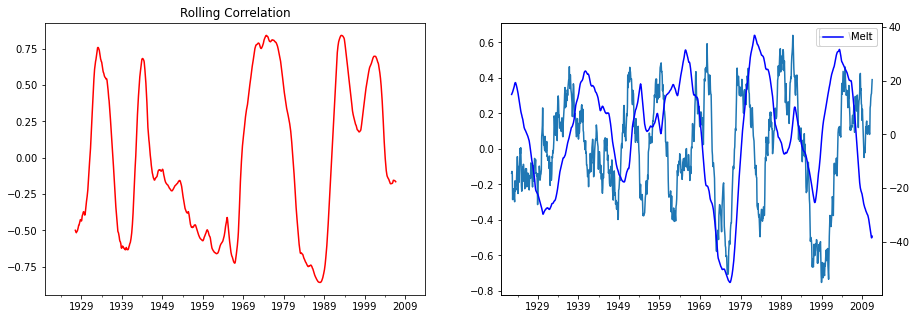

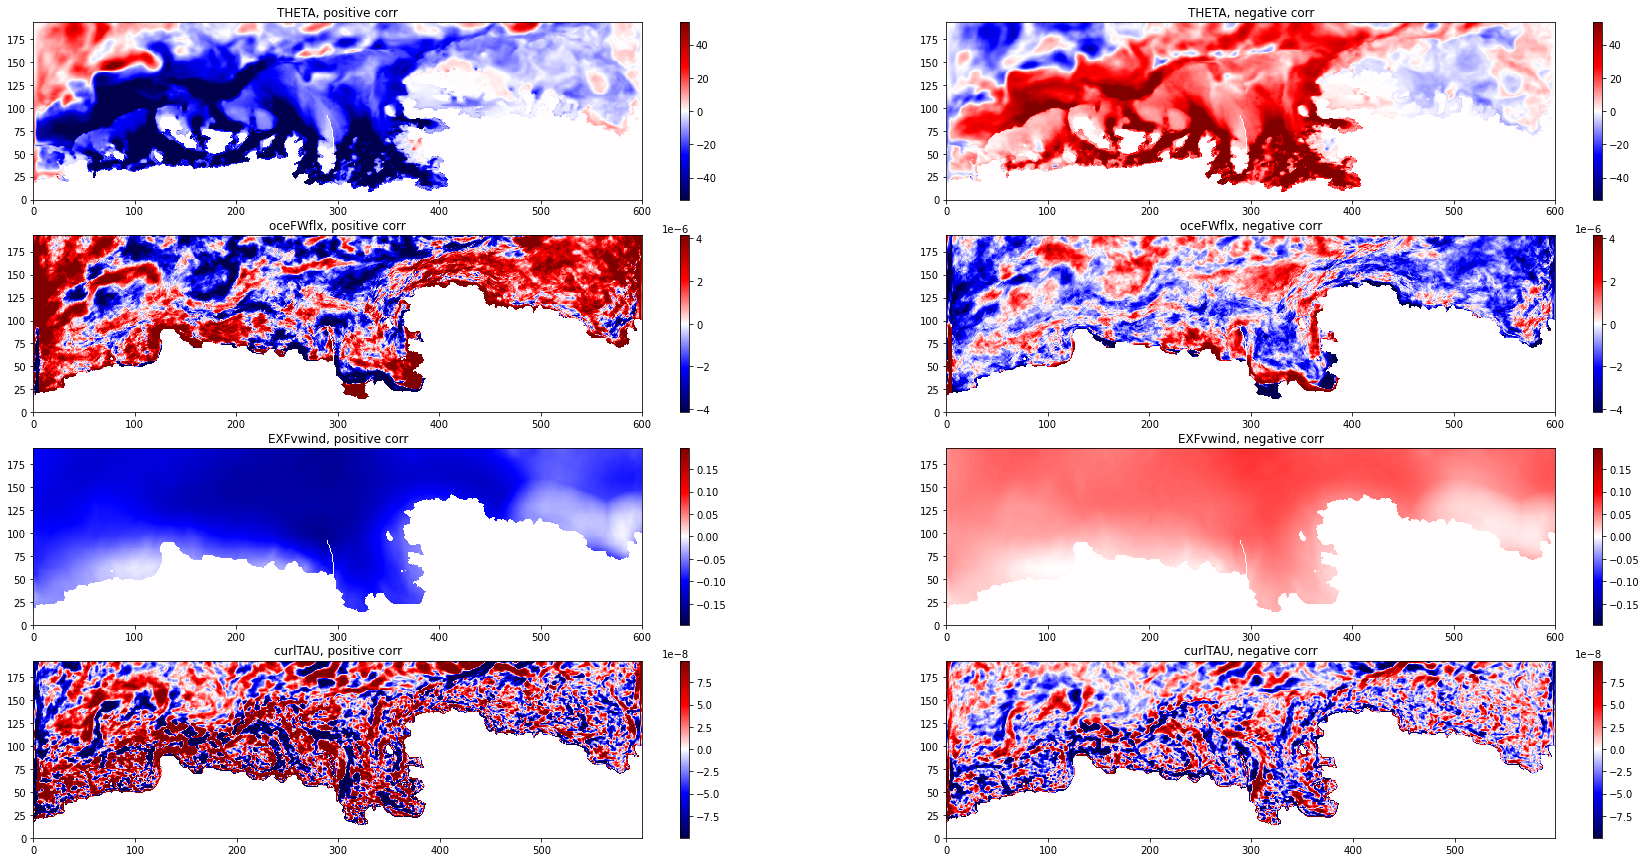

In [79]:
THETA1, THETA2, BUOY1, BUOY2, EXFvwind1, EXFvwind2, curlTAU1, curlTAU2=check_correlation(ens=3)
THETA1X=xr.concat([THETA1X, THETA1], dim='ens')
THETA2X=xr.concat([THETA2X, THETA2], dim='ens')

BUOY1X=xr.concat([BUOY1X, BUOY1], dim='ens')
BUOY2X=xr.concat([BUOY2X, BUOY2], dim='ens')

EXFvwind1X=xr.concat([EXFvwind1X, EXFvwind1], dim='ens')
EXFvwind2X=xr.concat([EXFvwind2X, EXFvwind2], dim='ens')

curlTAU1X=xr.concat([curlTAU1X, curlTAU1], dim='ens')
curlTAU2X=xr.concat([curlTAU2X, curlTAU2], dim='ens')

In [ ]:
THETA1, THETA2, BUOY1, BUOY2, EXFvwind1, EXFvwind2, curlTAU1, curlTAU2=check_correlation(ens=4)
THETA1X=xr.concat([THETA1X, THETA1], dim='ens')
THETA2X=xr.concat([THETA2X, THETA2], dim='ens')

BUOY1X=xr.concat([BUOY1X, BUOY1], dim='ens')
BUOY2X=xr.concat([BUOY2X, BUOY2], dim='ens')

EXFvwind1X=xr.concat([EXFvwind1X, EXFvwind1], dim='ens')
EXFvwind2X=xr.concat([EXFvwind2X, EXFvwind2], dim='ens')

curlTAU1X=xr.concat([curlTAU1X, curlTAU1], dim='ens')
curlTAU2X=xr.concat([curlTAU2X, curlTAU2], dim='ens')

/tmp/ipykernel_7770/1493048411.py:34: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  THETA['time']=THETA.indexes['time'].to_datetimeindex()
/tmp/ipykernel_7770/1493048411.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  BUOY['time']=BUOY.indexes['time'].to_datetimeindex()
/tmp/ipykernel_7770/1493048411.py:46: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between date

In [ ]:
THETA1, THETA2, BUOY1, BUOY2, EXFvwind1, EXFvwind2, curlTAU1, curlTAU2=check_correlation(ens=5)
THETA1X=xr.concat([THETA1X, THETA1], dim='ens')
THETA2X=xr.concat([THETA2X, THETA2], dim='ens')

BUOY1X=xr.concat([BUOY1X, BUOY1], dim='ens')
BUOY2X=xr.concat([BUOY2X, BUOY2], dim='ens')

EXFvwind1X=xr.concat([EXFvwind1X, EXFvwind1], dim='ens')
EXFvwind2X=xr.concat([EXFvwind2X, EXFvwind2], dim='ens')

curlTAU1X=xr.concat([curlTAU1X, curlTAU1], dim='ens')
curlTAU2X=xr.concat([curlTAU2X, curlTAU2], dim='ens')

In [ ]:
THETA1=THETA1X.mean(dim='ens')
THETA2=THETA2X.mean(dim='ens')

BUOY1=BUOY1X.mean(dim='ens')
BUOY2=BUOY2X.mean(dim='ens')

EXFvwind1=EXFvwind1X.mean(dim='ens')
EXFvwind2=EXFvwind2X.mean(dim='ens')

curlTAU1=curlTAU1X.mean(dim='ens')
curlTAU2=curlTAU2X.mean(dim='ens')


plt.figure(figsize=(30,15))
plt.subplot(4,2,1)
vmax=THETA1.quantile(0.95)
vmin=THETA1.quantile(0.05)
if vmax<abs(vmin):
    vmax=abs(vmin)

plt.pcolor(THETA1.where(THETA1.YC<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.title('THETA, positive corr')
plt.subplot(4,2,2)
plt.pcolor(THETA2.where(THETA2.YC<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.title('THETA, negative corr')

vmax=BUOY1.quantile(0.95)
vmin=BUOY1.quantile(0.05)
if vmax<abs(vmin):
    vmax=abs(vmin)

plt.subplot(4,2,3)
plt.pcolor(BUOY1.where(BUOY1.YC<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.title('oceFWflx, positive corr')
plt.subplot(4,2,4)
plt.pcolor(BUOY2.where(BUOY2.YC<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.title('oceFWflx, negative corr')


vmax=EXFvwind1.quantile(0.95)
vmin=EXFvwind1.quantile(0.05)
if vmax<abs(vmin):
    vmax=abs(vmin)
plt.subplot(4,2,5)
plt.pcolor(EXFvwind1.where(EXFvwind1.YC<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.title('EXFvwind, positive corr')
plt.subplot(4,2,6)
plt.pcolor(EXFvwind2.where(EXFvwind2.YC<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.title('EXFvwind, negative corr')


vmax=curlTAU1.quantile(0.95)
vmin=curlTAU1.quantile(0.05)
if vmax<abs(vmin):
    vmax=abs(vmin)
plt.subplot(4,2,7)
plt.pcolor(curlTAU1.where(curlTAU1.YG<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.title('curlTAU, positive corr')

plt.subplot(4,2, 8)
plt.pcolor(curlTAU2.where(curlTAU2.YG<-70, drop=True), cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.title('curlTAU, negative corr')

<xarray.DataArray 'curlTAU' (YG: 383, XG: 599)>
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 1.2823148e-07, -1.1696973e-07, -2.8170838e-08, ...,
        -4.3867772e-09, -2.6946566e-08, -2.4227916e-08],
       [ 1.3756562e-07, -8.9704940e-08, -9.8010560e-09, ...,
         9.2279500e-09, -2.0367004e-08, -2.1316993e-08],
       [ 4.1951216e-07,  1.1933716e-06,  1.1968496e-06, ...,
        -1.1003671e-08, -3.5817472e-08, -3.3608970e-08]], dtype=float32)
Coordinates:
  * YG       (YG) float32 -75.63 -75.6 -75.58 -75.55 ... -62.51 -62.46 -62.41
  * XG       (XG) float64 220.1 220.2 220.3 220.4 ... 279.6 279.7 279.8 279.9
    rAs      (YG, XG) float32 7.61e+06 7.61e+06 7.61e+06 ... 2.647e+07 2.647e+07
    dxG      (YG, XG) float32 2.76e+03 2.76e+03 2.76e+03 ... 5.149e+03 5.149e+03
    dyC      (YG, XG) float32 2.757e+03 2.757e+03 ... 5.142e+03 5.142e+03
    dxC      (YG, XG) float32 2.762e+03 2.762e+03 ... 5.153e+03 5.153e+03
    rAw      (YG, XG) float32 7.617e+06 7.617e+06 ... 2.652e+07 2.652e+07
    dyG      (YG, XG) float32 2.757e+03 2.757e+03 ... 5.148e+03 5.148e+03